# Assay Annotations
This notebook compares the sets of assays between badapple_classic and badapple2.

# Setup

In [286]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_usr>"
ORIGINAL_DB_PASSWORD = "<your_pw>"

COMPARISON_DB_NAME = "badapple2"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [287]:
# list of AIDs from ORIGINAL_DB
ORIGINAL_AID_PATH = "/home/jack/unm_gra/data/badapple/badapple1/badapple_tested.aid"
# list of AIDs from COMPARISON_DB
COMPARISON_AID_PATH = "/home/jack/unm_gra/data/badapple/badapple2/badapple2_tested.aid"

In [288]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

## Connect to DBs

In [289]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [290]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [291]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

## Read AID Files

In [292]:
def read_aid_file(aid_file_path: str) -> list[int]:
    with open(aid_file_path, "r") as file:
        aid_list = [int(line.strip()) for line in file if line.strip().isdigit()]
    return aid_list

In [293]:
ORIGINAL_AID_LIST = read_aid_file(ORIGINAL_AID_PATH)
COMPARISON_AID_LIST = read_aid_file(COMPARISON_AID_PATH)

In [294]:
print(len(set(ORIGINAL_AID_LIST)), len(set(COMPARISON_AID_LIST)))
print(len(set(ORIGINAL_AID_LIST) - set(COMPARISON_AID_LIST)))
print(len(set(COMPARISON_AID_LIST) - set(ORIGINAL_AID_LIST)))

823 906
0
83


# Fetch Assay Annotations
Annotations come from BARD.

In [295]:
ANN_COLUMNS = "aid,assay_format,assay_type,detection_method"
ANN_COLUMNS_LIST =  ANN_COLUMNS.split(",")

In [296]:
def get_assay_annotations(db_cursor, db_conn):
    query = sql.SQL(f"SELECT {ANN_COLUMNS} FROM aid2descriptors")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [297]:
COMPARISON_ASSAY_ANNOTATIONS = get_assay_annotations(comparison_db_cur, comparison_db_connection)

In [298]:
comparison_ann_df = pd.DataFrame(COMPARISON_ASSAY_ANNOTATIONS, columns=ANN_COLUMNS_LIST)
comparison_ann_df

,aid,assay_format,assay_type,detection_method
0,360,protein format,direct enzyme activity assay,fluorescence intensity
1,361,biochemical format,direct enzyme activity assay,absorbance method
2,368,protein format,direct enzyme activity assay,fluorescence intensity
3,373,cell-based format,reporter-gene assay,fluorescence resonance energy transfer
4,374,cell-based format,direct enzyme activity assay,fluorescence intensity
...,...,...,...,...
901,1671463,None,None,None
902,1745845,None,None,None
903,1745853,None,None,None
904,1745857,None,None,None


In [299]:
original_ann_df = comparison_ann_df[comparison_ann_df["aid"].isin(ORIGINAL_AID_LIST)]
original_ann_df

,aid,assay_format,assay_type,detection_method
0,360,protein format,direct enzyme activity assay,fluorescence intensity
1,361,biochemical format,direct enzyme activity assay,absorbance method
2,368,protein format,direct enzyme activity assay,fluorescence intensity
3,373,cell-based format,reporter-gene assay,fluorescence resonance energy transfer
4,374,cell-based format,direct enzyme activity assay,fluorescence intensity
...,...,...,...,...
841,1053133,None,None,None
843,1053197,None,None,None
844,1117264,None,None,None
845,1117267,None,None,None


# Process Data

In [300]:
def get_frequency_df(d: dict[str, list[str]] | pd.DataFrame, key: str, remove_str: str = None) -> pd.DataFrame:
    term_counts = Counter(d[key])
    df = pd.DataFrame(term_counts.items(), columns=['Term', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    # map None to "NULL"
    df["Term"] = df["Term"].map(lambda x: "NULL" if x is None else x)
    if remove_str is not None:
        df["Term"] = df["Term"].map(lambda x: x.replace(remove_str, ''))
    return df

In [301]:
def get_high_frequency_df(df: pd.DataFrame, thresh: int, freq_col: str = "Frequency") -> pd.DataFrame:
    # group terms with frequencies <= thresh under "Other" category
    df_high_freq = df[df[freq_col] > thresh]
    other_freq_sum = df[df[freq_col] <= thresh][freq_col].sum()
    i = len(df_high_freq)
    df_high_freq.loc[i] = ['OTHER', other_freq_sum]
    df_high_freq = df_high_freq.sort_values(by=freq_col, ascending=False).reset_index(drop=True)
    return df_high_freq

# Create plots

In [302]:
def plot_frequency_comparison(df1: pd.DataFrame, df2: pd.DataFrame, 
                              df1_label: str, df2_label: str, 
                              title_key: str, yscale: str = "linear",
                              xtick_labels: list[str] = None,
                              rotate_tick_labels: bool = True, 
                              xlabel: str = "Term",
                              ylabel: str = "Relative Frequency (%)",
                              title: str = None, 
                              label_bars: bool = False):
    fig, ax = plt.subplots(figsize=(10, 6))
    ind = np.arange(max(len(df1), len(df2)))
    width = 0.4

    total1 = df1["Frequency"].sum()
    total2 = df2["Frequency"].sum()
    df1["Relative Frequency"] = (df1["Frequency"] / total1 * 100) if total1 > 0 else 0
    df2["Relative Frequency"] = (df2["Frequency"] / total2 * 100) if total2 > 0 else 0

    df1_label += f"\nN={total1}"
    df2_label += f"\nN={total2}"
    bars1 = ax.bar(ind, df1["Relative Frequency"], width=width, label=df1_label, color='skyblue')
    bars2 = ax.bar(ind + width, df2["Relative Frequency"], width=width, label=df2_label, color='orange')

    ax.set_xlabel(xlabel)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    if title is not None:
        plt.title(title)
    else:
        plt.title(f'Relative Frequency of {title_key} Terms')
    ax.legend()

    if xtick_labels is not None:
        ax.set_xticks(ind + width / 2)
        ax.set_xticklabels(xtick_labels)

    if rotate_tick_labels:
        plt.xticks(rotation=45, ha='right')

    if label_bars:
        for bar, freq in zip(bars1, df1["Relative Frequency"]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    f"{freq:.1f}%", ha='center', va='bottom', fontsize=8)

        for bar, freq in zip(bars2, df2["Relative Frequency"]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    f"{freq:.1f}%", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

## Assay Format

In [303]:
remove_str = " format"
key = "assay_format"
title_key = "Assay Format"

In [304]:
df1 = get_frequency_df(original_ann_df, key, remove_str)
df2 = get_frequency_df(comparison_ann_df, key, remove_str)

In [305]:
print(df1.head())
print(df2.head())

             Term  Frequency
0      cell-based        319
1            NULL        155
2  single protein         89
3     biochemical         87
4         protein         84
             Term  Frequency
0      cell-based        331
1            NULL        220
2  single protein         94
3     biochemical         88
4         protein         84


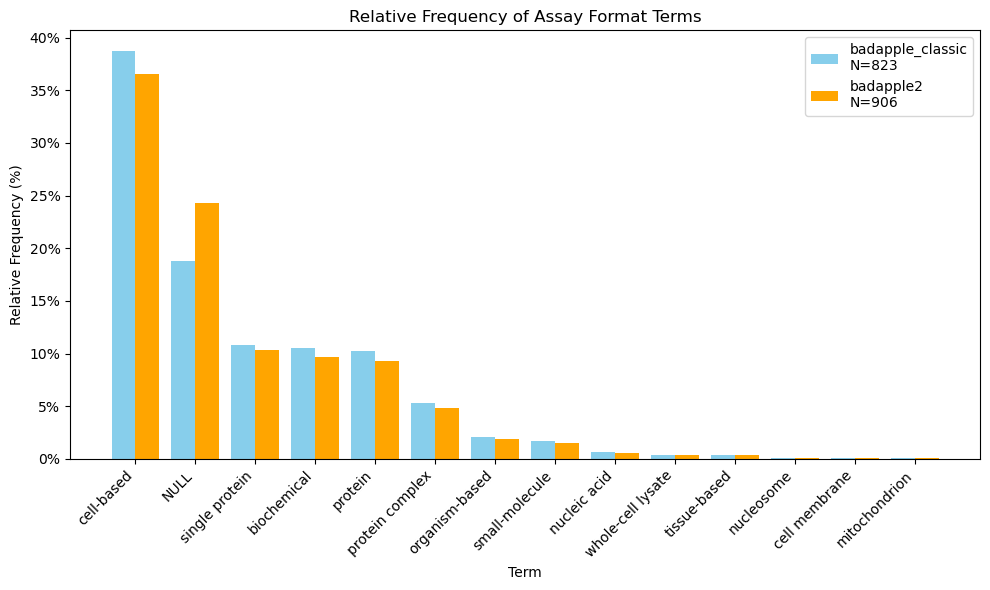

In [306]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          title_key, xtick_labels=list(df1["Term"]), label_bars=False)

## Assay Format

In [307]:
remove_str = " assay"
key = "assay_type"
title_key = "Assay Type"

In [308]:
df1 = get_frequency_df(original_ann_df, key, remove_str)
df2 = get_frequency_df(comparison_ann_df, key, remove_str)

In [309]:
df1 = get_high_frequency_df(df1, 5)
df2 = get_high_frequency_df(df2, 5)

/tmp/ipykernel_52516/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_52516/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


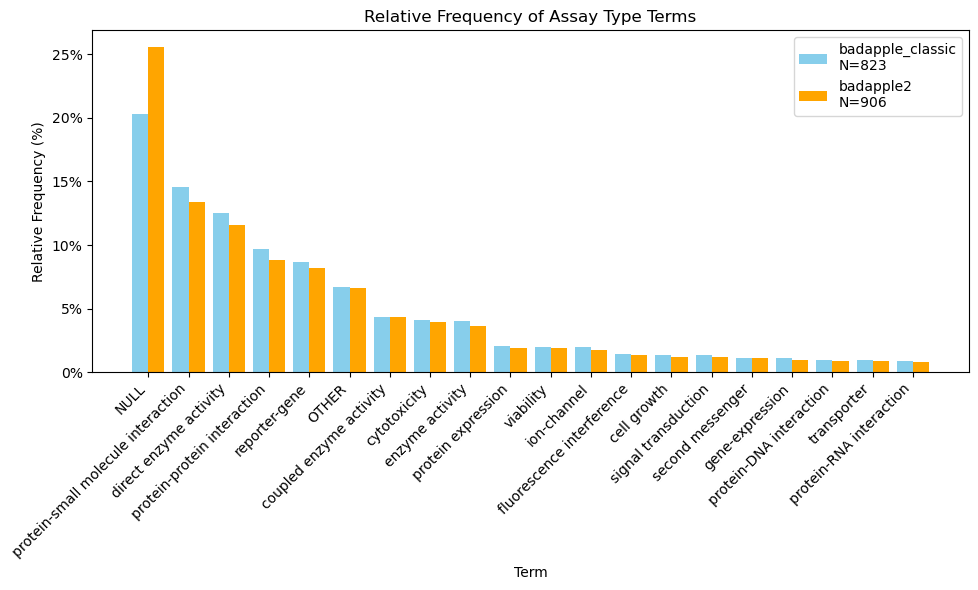

In [310]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          title_key, xtick_labels=list(df1["Term"]), label_bars=False)

## Detection Method

In [311]:
remove_str = " assay"
key = "detection_method"
title_key = "Detection Method"

In [312]:
df1 = get_frequency_df(original_ann_df, key, remove_str)
df2 = get_frequency_df(comparison_ann_df, key, remove_str)

In [313]:
df1 = get_high_frequency_df(df1, 5)
df2 = get_high_frequency_df(df2, 5)

/tmp/ipykernel_52516/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]
/tmp/ipykernel_52516/2689725211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_freq.loc[i] = ['OTHER', other_freq_sum]


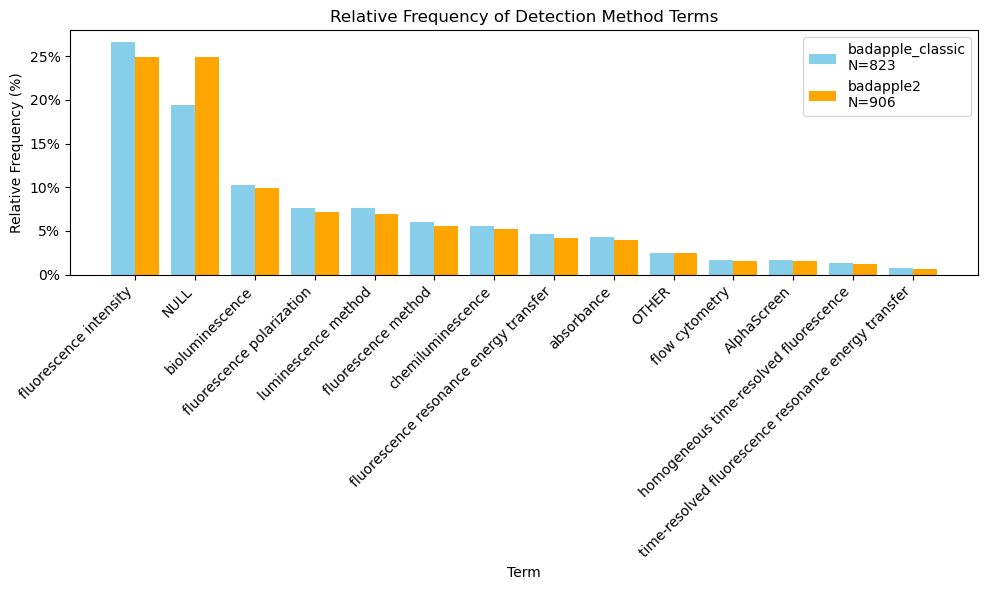

In [314]:
plot_frequency_comparison(df1, df2, ORIGINAL_DB_NAME, COMPARISON_DB_NAME, 
                          title_key, xtick_labels=list(df1["Term"]), label_bars=False)

# Close DB Connections

In [315]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()